# Plan:
- 1. Create a dataset that describes the "major" characteristics of each playlist:
    - Average popularity score
    - Mode of year of album release 
    - Mode of artist
    
- 2. Cluster using DBSCAN.
- 3. Recommend the song that appears the most in the cluster and isn't already found in Vetting playlist.

In [1]:
import pandas as pd
import json
import requests
from datetime import datetime
import math
import os
import time
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import seaborn as sns

### Setup Spotify API Authorization token 

In [2]:
def get_token(client_id, client_secret):
    '''
    Returns the unique token needed to use the Spotify API.
    You do not need to change anything about the body of this function.
    
    Parameters:
        - client_id: A unique string that is provided to you when you setup a Spotify API account
        - client_secret: A unique string that is provided to you when you setup a Spotify API account
    '''
    token_url = 'https://accounts.spotify.com/api/token'
    
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    
    data = {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret
    }
    
    response = requests.post(token_url, headers=headers, data=data)
    return response.json()

In [3]:
client_id = 'YOUR ID HERE' # ADD YOUR CLIENT ID HERE
client_secret = 'YOUR SECRET HERE' # ADD YOUR CLIENT SECRET HERE

token_response = get_token(client_id, client_secret)
# access_token = token_response['access_token']
# headers = {Authorization': 'Bearer ' + access_token}

### Get data for Ms. Spindt's playlist

In [4]:
# Read in Ms. Spindt's playlist
with open('vetting_playlist.json', 'r') as file:
    vetting = json.load(file)['tracks']['items']

In [5]:
def get_avg_pop_vetting(playlist):
    '''
    Returns the average popularity score of all tracks found in a playlist.
    
    Parameters:
        - playlist: a list of json objects.
    '''
    total = 0
    count = 0
    for track in playlist:
        pop_score = track['track']['popularity']
        if pop_score:
            total += pop_score
            count += 1
    return total/count

In [6]:
def get_mode_year_vetting(playlist):
    '''
    Returns the most frequent year for album release in the playlist.
    
    Parameters:
        - playlist: a list of json objects.
    '''
    counts = {}
    for track in playlist:
        date = track['track']['album']['release_date']
        if date:
            year = date.split('-')[0] # The date is a string that follows the pattern: year - month - day
            if year not in counts.keys():
                counts[year] = 1
            else:
                counts[year] += 1  
    return int(max(counts.items(), key=lambda x: x[1])[0]) # Determines which year appears the most and returns it

In [7]:
def get_mode_artist_vetting(playlist):
    '''
    Returns the most common artist found in the playlist.
    
    Parameters:
        - playlist: a list of json objects.
    '''
    counts = {}
    for track in playlist:
        artist = track['track']['artists'][0]['name'] # Ignoring secondary artists
        if artist not in counts.keys():
            counts[artist] = 1
        else:
            counts[artist] += 1
    return max(counts.items(), key=lambda x: x[1])[0] # Determines which artist appears the most and returns it

In [8]:
# Gets average popularity score, most frequent year for album release, and most frequent artist for Ms. Spindt's playlist
vetting_avg_pop = get_avg_pop_vetting(vetting)
vetting_year = get_mode_year_vetting(vetting)
vetting_artist = get_mode_artist_vetting(vetting)

### Get data for the first 1000 Spotify playlists

In [9]:
# Read in the first 1000 playlists from the Spotify Million 
with open('first_file.json', 'r') as file:
    playlists = json.load(file)['playlists'] # Notice this does not use the same structure as vetting_playlist.json

In [10]:
def get_batch_track_info(uris):
    '''
    Returns a tuple uris and track info using the '/tracks' endpoint.
    The 'tracks' endpoint can only retrieve info for at most 50 songs at a time
    
    Parameters:
        - uris: a list of uri strings.
    '''
    combo = ','.join(uris)
    response = requests.get("https://api.spotify.com/v1/tracks?ids=" + combo, headers=headers)

    # Check if request was successful
    if response.status_code == 200:
        return zip(uris, response.json()['tracks']) # This pairs each track URI with its info json payload
    
    # If token expired, refresh and call get_batch_track_info again
    elif response.status_code == 401:
        token_response = get_token(client_id, client_secret)
        access_token = token_response['access_token']
        headers['Authorization'] = 'Bearer ' + access_token
        return get_batch_track_info(uris)
    else:
        raise Exception(f"Failed to fetch tracks: {response.status_code} {response.text}")

In [11]:
def find_empty_tracks(tracks):
    '''
    Returns a list of songs that I have not requested info from.
    
    Parameters:
        - tracks: a list of Spotify uris.
    '''
    todo = []
    for uri,info in tracks.items():
        if not info:
            todo.append(uri)
    return todo

In [12]:
# Create a json file of the data just in case something happens to while making requests to the Spotify API
# The file makes it so I can start from where I left off.

# json_file = "playlist_tracks.json"
# if not os.path.exists(json_file):
#     with open(json_file, 'w') as file:
#         json.dump({}, file)

In [13]:
# Code needed to make requests to Spotify API in 50 track batches
# After each batch, the json payload is saved to the json file

# with open(json_file, 'r') as file:
#     unique_tracks = json.load(file)
    
# for playlist in playlists:
#     for track in playlist['tracks']:
#         uri = track['track_uri'].split(':')[2]
#         if uri not in unique_tracks.keys():
#             unique_tracks[uri] = {}

# empty_tracks = find_empty_tracks(unique_tracks)

# groups = math.ceil(len(empty_tracks) / 50)
# for i in range(groups):
#     print(f'processing {i+1}/{groups} {datetime.now()}')
#     chunk = empty_tracks[-50:]
#     track_info = get_batch_track_info(chunk)
#     for uri, payload in track_info:
#         unique_tracks[uri] = payload
#         with open(json_file, 'w') as file:
#             json.dump(unique_tracks, file)
#     del empty_tracks[-50:]

In [14]:
# Open the json file created from Spotify API
with open('playlist_tracks.json', 'r') as file:
    all_data = json.load(file)

len(all_data)

34443

In [15]:
def get_avg_pop(playlist):
    '''
    Returns the average popularity score for a playlist from the first 1000 playlists in the Spotify Million.
        - A separate function is needed because the structure of the Spotify Million dataset differs from Vetting.
        - There are some small errors in the data that require additional validation. 
            - For example, one Tim McGraw song is missing the 'popularity' section.
    
    Parameters:
        - playlist: a json object.
    '''
    total = 0
    for track in playlist['tracks']:
        uri = track['track_uri'].split(':')[2]
        if all_data[uri]:
            if 'popularity' in all_data[uri].keys():
                pop_score = all_data[uri]['popularity']
                total += pop_score
    return float((total / len(playlist['tracks'])))

In [16]:
def get_top_release_year(playlist):
    '''
    Returns the most frequent year an album was released from the first 1000 playlists in the Spotify Million.
       - A separate function is needed because the structure of the Spotify Million dataset differs from Vetting.
        - There are some small errors in the data that require additional validation. 
            - For example, one Tim McGraw song is missing the 'popularity' section.
            
    Parameters:
        - playlist: a json object.
    '''
    counts = {}
    for track in playlist['tracks']:
        uri = track['track_uri'].split(':')[2]
        if all_data[uri]:
            if 'album' in all_data[uri].keys() and 'release_date' in all_data[uri]['album']:
                    date = all_data[uri]['album']['release_date']
                    if date: 
                        year = date.split('-')[0] # The date is a string that follows the pattern: year - month - day
                        if year not in counts.keys():
                            counts[year] = 1
                        else:
                            counts[year] += 1 
            
    return int(max(counts.items(), key=lambda x: x[1])[0]) # Determines which year appears the most and returns it

In [17]:
def get_top_artist(playlist):
    '''
    Returns the most frequent artist that appears in a playlist from the Spotify Million.
    A separate function is needed because the structure of the Spotify Million dataset differs from Vetting.
    
    Parameters:
        - playlist: a json object.
    '''
    counts = {}
    for track in playlist['tracks']:
        artist = track['artist_name']
        if artist not in counts.keys():
            counts[artist] = 1
        else:
            counts[artist] += 1  
    return max(counts.items(), key=lambda x: x[1])[0] # Determines which year appears the most and returns it

In [18]:
df = {
    'id': [], 
    'avg_popularity': [],
    'top_year': [],
    'top_artist': []
}

for playlist in playlists:
    df['id'].append(playlist['pid'])
    df['avg_popularity'].append(get_avg_pop(playlist))
    df['top_year'].append(get_top_release_year(playlist))
    df['top_artist'].append(get_top_artist(playlist))

In [19]:
df = pd.DataFrame(df)

# Ms. Spindt's playlist will be last in dataframe
df.loc[1000] = {
    'id': 1000,
    'avg_popularity': vetting_avg_pop,
    'top_year': vetting_year,
    'top_artist': vetting_artist
}

df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1001 non-null   int64  
 1   avg_popularity  1001 non-null   float64
 2   top_year        1001 non-null   int64  
 3   top_artist      1001 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 39.1+ KB


### Train/Test a DBSCAN Model

In [21]:
X = df[['avg_popularity', 'top_year']]
radius_tests = np.arange(0.1, 100.0, 0.1) # list of values to try for eps
max_sil = {
    'max_sil_score': 0,
    'eps': 0,
    'min_samps': 0
}
for sample in range(30, 100):
    print("Sample:", sample)
    print("Max Silhouette Score", max_sil['max_sil_score'])
    for val in radius_tests:
        model = DBSCAN(eps=val, min_samples=sample).fit(X)
        if len(set(model.labels_)) > 2: # Checks if more than 1 cluster was found
            new_sil_score = silhouette_score(X, model.fit_predict(X))
            current_high_score = max_sil['max_sil_score']
            if new_sil_score > current_high_score:
                max_sil['max_sil_score'] = new_sil_score
                max_sil['eps'] = val
                max_sil['min_samps'] = sample

Sample: 30
Max Silhouette Score 0
Sample: 31
Max Silhouette Score 0.5872495678352738
Sample: 32
Max Silhouette Score 0.58782220205284
Sample: 33
Max Silhouette Score 0.5895578427526567
Sample: 34
Max Silhouette Score 0.5959452263891356
Sample: 35
Max Silhouette Score 0.5975218617534191
Sample: 36
Max Silhouette Score 0.5975218617534191
Sample: 37
Max Silhouette Score 0.5975218617534191
Sample: 38
Max Silhouette Score 0.5975218617534191
Sample: 39
Max Silhouette Score 0.5975218617534191
Sample: 40
Max Silhouette Score 0.5975218617534191
Sample: 41
Max Silhouette Score 0.5975218617534191
Sample: 42
Max Silhouette Score 0.5975218617534191
Sample: 43
Max Silhouette Score 0.5975218617534191
Sample: 44
Max Silhouette Score 0.5975218617534191
Sample: 45
Max Silhouette Score 0.5975218617534191
Sample: 46
Max Silhouette Score 0.5975218617534191
Sample: 47
Max Silhouette Score 0.5975218617534191
Sample: 48
Max Silhouette Score 0.5975218617534191
Sample: 49
Max Silhouette Score 0.5975218617534191

### Results

<AxesSubplot:xlabel='avg_popularity', ylabel='top_year'>

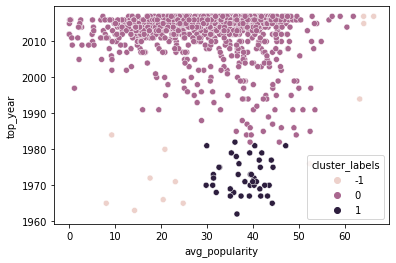

In [22]:
# Best Model:
model = DBSCAN(eps=max_sil['eps'], min_samples=max_sil['min_samps']).fit(X)
df['cluster_labels'] = model.labels_

sns.scatterplot(data=df, x='avg_popularity', y='top_year', hue='cluster_labels')

In [23]:
# Ms. Spindt's playlist is in cluster 0
df.tail()

,id,avg_popularity,top_year,top_artist,cluster_labels
996,996,44.941176,2016,Kehlani,0
997,997,23.739496,2013,Lil Wayne,0
998,998,40.787037,2013,Rascal Flatts,0
999,999,20.431818,2015,Rusty Clanton,0
1000,1000,44.316456,2017,Angel Olsen,0


In [45]:
# Determine the most frequent song for all playlists in cluster 0
count = {}
cluster_0 = df[df['cluster_labels'] == 0]
for pid in cluster_0['id']:
    for playlist in playlists:
        if playlist['pid'] == pid:
            for track in playlist['tracks']:
                uri = track['track_uri'].split(':')[2]
                if uri not in count.keys():
                    count[uri] = 1
                else:
                    count[uri] += 1

uri = max(count.items(), key=lambda x: x[1])

In [46]:
uri

('1xznGGDReH1oQq0xzbwXa3', 55)

In [43]:
all_data['1xznGGDReH1oQq0xzbwXa3']

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3TVXtAsR1Inumwj472S9r4'},
    'href': 'https://api.spotify.com/v1/artists/3TVXtAsR1Inumwj472S9r4',
    'id': '3TVXtAsR1Inumwj472S9r4',
    'name': 'Drake',
    'type': 'artist',
    'uri': 'spotify:artist:3TVXtAsR1Inumwj472S9r4'}],
  'available_markets': [],
  'external_urls': {'spotify': 'https://open.spotify.com/album/3hARKC8cinq3mZLLAEaBh9'},
  'href': 'https://api.spotify.com/v1/albums/3hARKC8cinq3mZLLAEaBh9',
  'id': '3hARKC8cinq3mZLLAEaBh9',
  'images': [{'url': 'https://i.scdn.co/image/ab67616d0000b273726abca207567d5e41cb9667',
    'width': 640,
    'height': 640},
   {'url': 'https://i.scdn.co/image/ab67616d00001e02726abca207567d5e41cb9667',
    'width': 300,
    'height': 300},
   {'url': 'https://i.scdn.co/image/ab67616d00004851726abca207567d5e41cb9667',
    'width': 64,
    'height': 64}],
  'name': 'Views',
  'release_date': '2016-05-06',
  'release_date_precision'